<a href="https://colab.research.google.com/github/JaiRamteke/Diabetes_Prediction_Model_Optimization_and_Deployment/blob/main/Diabetes_Prediction_Model_Optimization_and_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
# --- Project Setup: Model Training & Evaluation with Visualization ---

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
!pip install scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, r2_score, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')
!pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Ensure directories exist
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('dashboard', exist_ok=True)

In [198]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "diabetes.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "uciml/pima-indians-diabetes-database",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

In [199]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


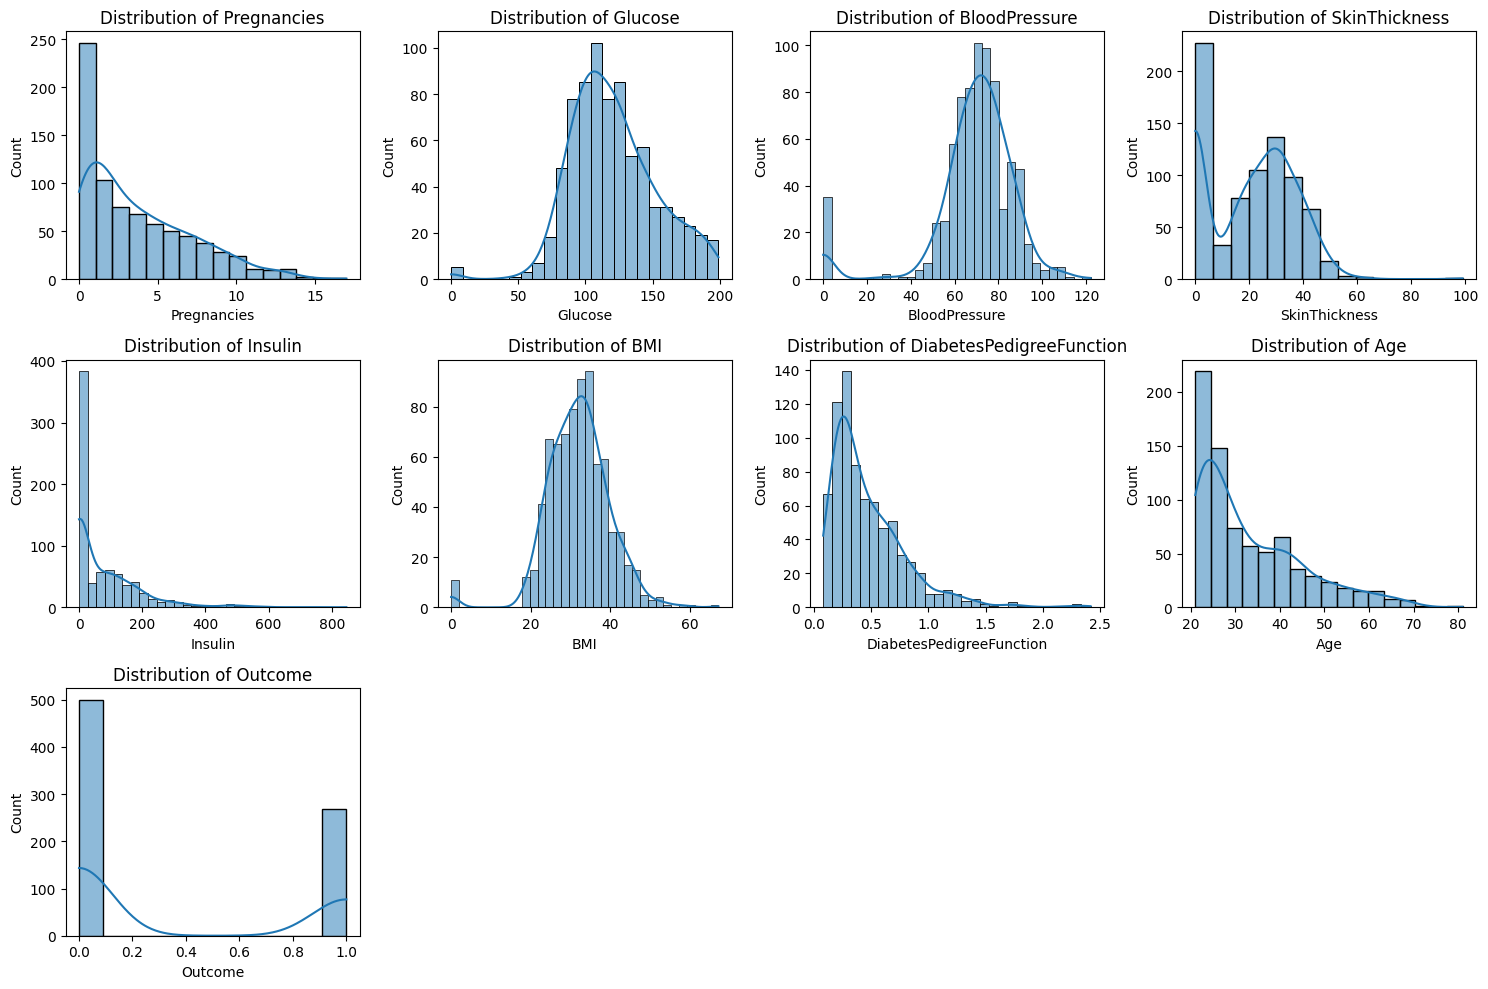

In [200]:
# ------------------ Data Preparation ------------------

# Visualize the distribution of features
plt.figure(figsize=(15, 10))
feature_names = df.columns
for i, feature in enumerate(feature_names):
    plt.subplot(3, 4, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
output_dir = 'plots'
plt.savefig(os.path.join(output_dir, 'feature_distributions.png'))

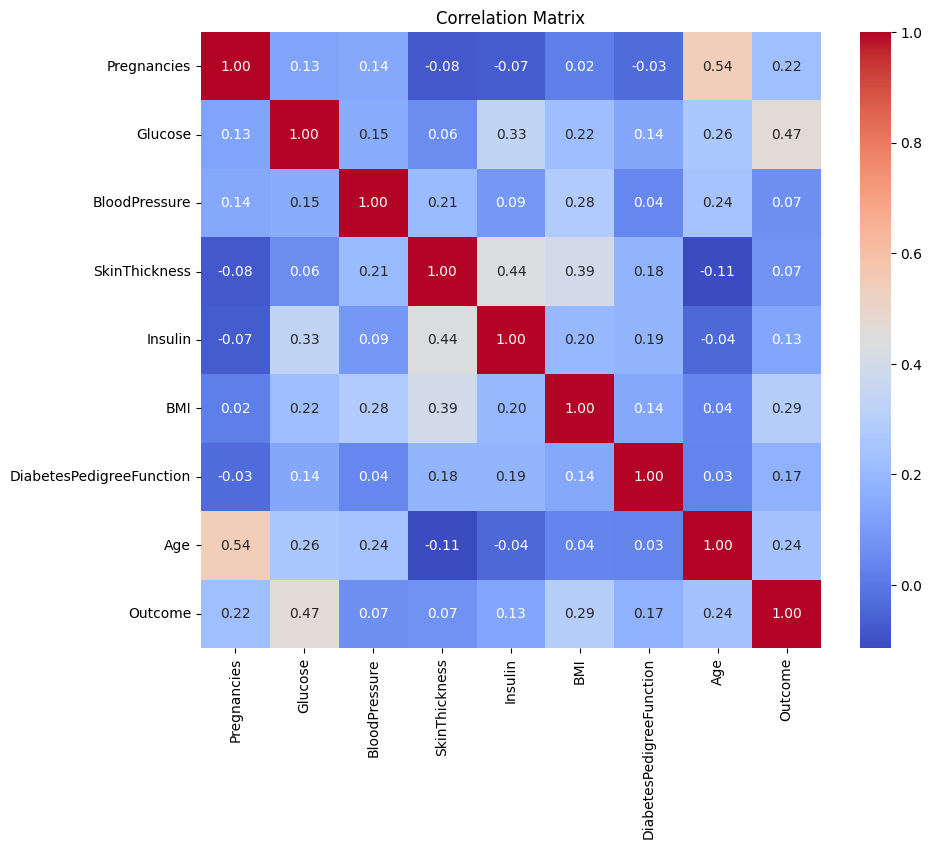

In [201]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('plots/correlation_matrix.png')
plt.show()

In [202]:
# Define target and features
target = 'Outcome'  # Change this to your actual target column name
# Replacing 'data' with 'df' since 'df' holds the DataFrame
X = df.drop(columns=[target])
y = df[target]

In [203]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [204]:
# Save test data for dashboard use
X_test.to_csv('dashboard/X_test.csv', index=False)
y_test.to_csv('dashboard/y_test.csv', index=False)

In [205]:
# ------------------ Model Definition ------------------

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [206]:
# Function to evaluate model
def evaluate_model(name, model, X_test, y_test, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'R2 Score': r2_score(y_test, y_pred)
    }

# Evaluate all models and store results
results = []
for name, model in models.items():
    model_results = evaluate_model(name, model, X_test, y_test, X_train, y_train)
    results.append(model_results)

# Create a pandas DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results
display(results_df)


,Model,Accuracy,Precision,Recall,F1 Score,R2 Score
0,Logistic Regression,0.746753,0.750154,0.746753,0.748167,-0.103030
1,Decision Tree,0.720779,0.730214,0.720779,0.724015,-0.216162
2,Random Forest,0.753247,0.757844,0.753247,0.755032,-0.074747
3,SVM,0.766234,0.761336,0.766234,0.758601,-0.018182
4,Gradient Boosting,0.746753,0.750154,0.746753,0.748167,-0.103030


<Figure size 1400x800 with 0 Axes>

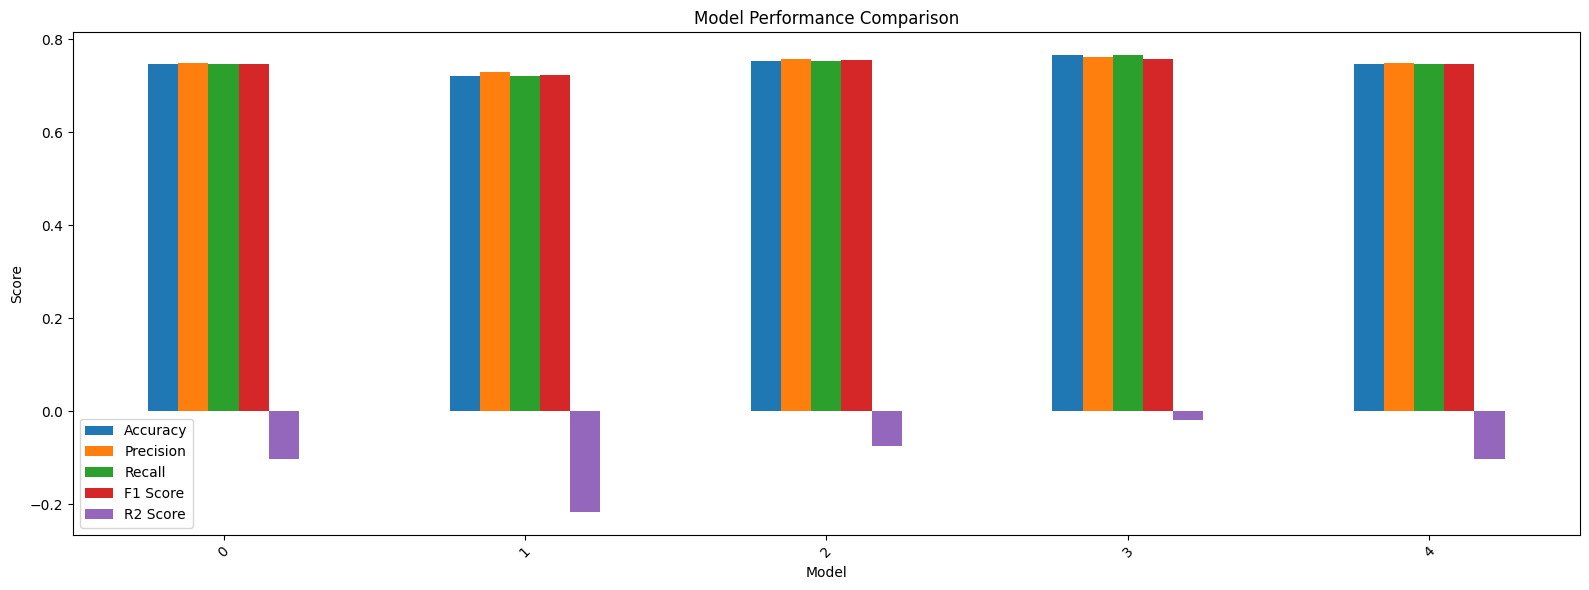

In [207]:
# Visualize model performance
plt.figure(figsize=(14, 8))
results_df.plot(kind='bar', figsize=(16, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'initial_model_performance.png'))

In [209]:
# =============================================
# 4. HYPER-PARAMETER TUNING
# =============================================

# Define a preprocessor, for example, StandardScaler:
preprocessor = StandardScaler()

# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__max_iter': [1000, 2000, 5000]
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 3, 5, 10, 15, 20, 25],
        'classifier__min_samples_split': [2, 5, 10, 15, 20],
        'classifier__min_samples_leaf': [1, 2, 4, 6, 8]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 150, 200, 250],
        'classifier__max_depth': [None, 5, 10, 15, 20, 25],
        'classifier__min_samples_split': [2, 5, 10, 15, 20],
        'classifier__min_samples_leaf': [1, 2, 4, 6, 8]
    },
    'SVM': {
        'classifier__C': [0.01, 0.1, 1, 10, ],
        'classifier__kernel': ['linear', 'rbf',],
        'classifier__gamma': ['scale', 'auto', 0.1, 1]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [25, 50, 75, 100, 125],
        'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'classifier__max_depth': [2, 3, 4, 5, 6]
    }
}

# Perform tuning
tuned_models = {}
tuning_results = {}
best_model = None
best_params = {}
feature_importances = {}

for name in models.keys():
    print(f"\nTuning {name}...")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', models[name])
    ])

    # Use RandomizedSearchCV for more efficient exploration
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grids[name],  # Use param_distributions
        n_iter=50,  # Number of iterations
        cv=3,
        scoring='accuracy',  # You can experiment with other scoring metrics
        n_jobs=-1,
        verbose=2,
        random_state=42  # Set random state for reproducibility
    )

    random_search.fit(X_train, y_train)
    tuned_models[name] = random_search.best_estimator_
    tuning_results[name] = random_search.best_params_

    print(f"Best parameters for {name}: {random_search.best_params_}")
    print(f"Best accuracy: {random_search.best_score_:.4f}")

    if best_model is None or random_search.best_score_ > best_model_score:
        best_model = random_search.best_estimator_
        best_model_score = random_search.best_score_  # Store the best score
        best_params = random_search.best_params_




Tuning Logistic Regression...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters for Logistic Regression: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__max_iter': 2000, 'classifier__C': 0.1}
Best accuracy: 0.7720

Tuning Decision Tree...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters for Decision Tree: {'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 5}
Best accuracy: 0.7655

Tuning Random Forest...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters for Random Forest: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20}
Best accuracy: 0.7883

Tuning SVM...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters for SVM: {'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__C': 1}
Best accuracy: 0.7670

In [210]:
# Evaluate tuned models
def evaluate_model(model, X_test, y_test):
    """Evaluates a model and returns a dictionary of performance metrics."""

    y_pred = model.predict(X_test)

    try:
        y_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1
    except AttributeError:
        y_prob = None  # If predict_proba is not available, set to None

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'R2 Score': r2_score(y_test, y_pred),
        'y_pred': y_pred,
        'y_prob': y_prob
    }

    return metrics

# Evaluate original models
results = {}
for name, model in models.items():  # Using trained_models for original models
    results[name] = evaluate_model(model, X_test, y_test)

tuned_results = {}
for name, model in tuned_models.items():
    tuned_results[name] = evaluate_model(model, X_test, y_test)

tuned_results_df = pd.DataFrame(tuned_results).T
tuned_results_df = tuned_results_df.reset_index()
tuned_results_df = tuned_results_df.rename(columns={'index': 'model'})
tuned_results_df.to_csv('model_results.csv', index=False)
model_results = pd.read_csv('model_results.csv')
print("\nTuned Model Evaluation Results:")
display(tuned_results_df)


Tuned Model Evaluation Results:


,model,Accuracy,Precision,Recall,F1 Score,R2 Score,y_pred,y_prob
0,Logistic Regression,0.75974,0.673077,0.636364,0.654206,-0.046465,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[0.30513145210151066, 0.23116580104036893, 0.1..."
1,Decision Tree,0.792208,0.744681,0.636364,0.686275,0.094949,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, ...","[0.4246575342465753, 0.04, 0.0, 0.0, 0.0, 0.42..."
2,Random Forest,0.746753,0.642857,0.654545,0.648649,-0.10303,"[0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, ...","[0.4068571428571429, 0.22567460317460308, 0.14..."
3,SVM,0.75974,0.666667,0.654545,0.66055,-0.046465,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, ...","[0.2637505168478767, 0.1896851986521246, 0.140..."
4,Gradient Boosting,0.733766,0.616667,0.672727,0.643478,-0.159596,"[1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, ...","[0.6146409448798109, 0.0032003723030448066, 0...."


<Figure size 1400x800 with 0 Axes>

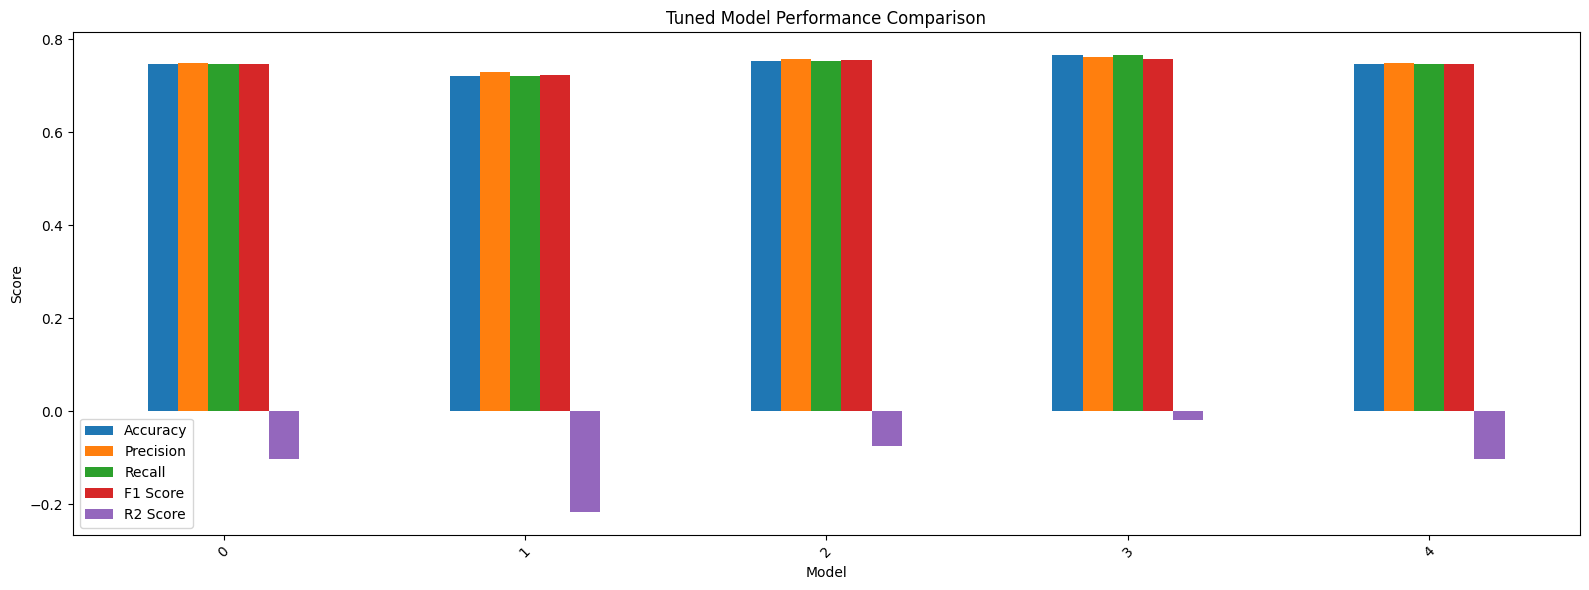

In [211]:
tuned_results_df = tuned_results_df.reset_index()  # Reset index for plotting

# Visualize model performance
plt.figure(figsize=(14, 8))
results_df.plot(kind='bar', figsize=(16, 6))
plt.title('Tuned Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'initial_model_performance.png'))

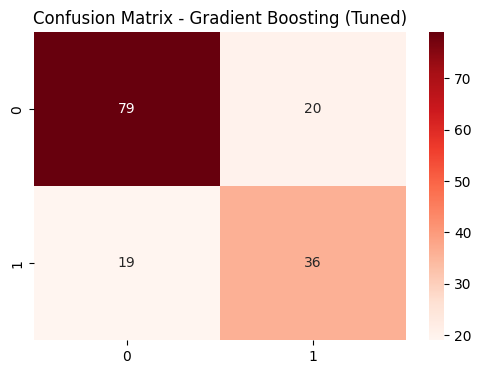

In [212]:
# Save best model
with open(f'models/{name.replace(" ", "_").lower()}_tuned.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save confusion matrix
    cm = confusion_matrix(y_test, best_model.predict(X_test))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.title(f'Confusion Matrix - {name} (Tuned)')
    plt.savefig(f'plots/confusion_matrix_{name.replace(" ", "_").lower()}_tuned.png')
    plt.show()

In [213]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importances[name + ' (Tuned)'] = best_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importance - {name} (Tuned)')
    plt.tight_layout()
    plt.show()

# Save tuned results
tuned_results_df = pd.DataFrame(tuned_results)
tuned_results_df.to_csv('results/tuned_results.csv', index=False)

# Save best parameters
best_params_df = pd.DataFrame.from_dict(best_params, orient='index')
best_params_df.to_csv('results/best_parameters.csv')

# Save feature importances
if feature_importances:
    feature_importances_df = pd.DataFrame(feature_importances, index=X.columns)
    feature_importances_df.to_csv('results/feature_importances.csv')

In [214]:
# =============================================
# 5. DASHBOARD CREATION
# =============================================

def create_dashboard(original_results, tuned_results):
    """Create interactive dashboard comparing model performance"""

    # Define metrics here within the function's scope
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'R2 Score']

    # Combine results
    original_results_df = pd.DataFrame.from_dict(original_results, orient='index') # Changed this line to create DataFrame with index
    original_results_df = original_results_df.reset_index()  # Reset index for plotting
    original_results_df['Type'] = 'Original'

    tuned_results_df = pd.DataFrame.from_dict(tuned_results, orient='index') # Changed this line to create DataFrame with index
    tuned_results_df = tuned_results_df.reset_index() # Reset index for plotting
    tuned_results_df['Type'] = 'Tuned'

    tuned_results_df.to_csv('model_results.csv', index=False)

    combined_df = pd.concat([original_results_df, tuned_results_df])



    # Create figures
    fig = make_subplots(
        rows=1, cols=5,  # Updated to 1 row, 5 columns
        subplot_titles=('Accuracy', 'Precision', 'Recall', 'F1 Score', 'R2 Score'),
        specs=[[{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}]]
    )


    positions = [(1,1), (1,2), (1,3), (1,4), (1,5)]  # Updated positions

    for metric, pos in zip(metrics, positions):
        fig.add_trace(
            go.Bar(
                x=combined_df['index'],
                y=combined_df[metric],
                marker_color=combined_df['Type'].map({'Original': 'blue', 'Tuned': 'green'}),
                name=metric,
                legendgroup=metric,
                showlegend=(metric=='Accuracy')
            ),
            row=pos[0], col=pos[1]
        )


    # Update layout (adjust for the removed subplot)
    fig.update_layout(
        title='Model Performance Comparison: Original vs Tuned',
        height=400,  # Adjusted height
        width=1500,
        legend_title='Model Type',
        hovermode='x unified',

    )


    # Show the figure
    fig.show()

    # Print summary
    print("\n=== KEY INSIGHTS ===")
    print(f"Best performing model: {tuned_results_df['Accuracy'].idxmax()}")
    print(f"Accuracy improvement after tuning: {tuned_results_df['Accuracy'].max() - original_results_df['Accuracy'].max():.4f}")
    print("\nTop models after tuning:")
    display(tuned_results_df.sort_values('Accuracy', ascending=False))

# Create the dashboard
create_dashboard(results, tuned_results)


=== KEY INSIGHTS ===
Best performing model: 1
Accuracy improvement after tuning: 0.0260

Top models after tuning:


,index,Accuracy,Precision,Recall,F1 Score,R2 Score,y_pred,y_prob,Type
1,Decision Tree,0.792208,0.744681,0.636364,0.686275,0.094949,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, ...","[0.4246575342465753, 0.04, 0.0, 0.0, 0.0, 0.42...",Tuned
0,Logistic Regression,0.759740,0.673077,0.636364,0.654206,-0.046465,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[0.30513145210151066, 0.23116580104036893, 0.1...",Tuned
3,SVM,0.759740,0.666667,0.654545,0.660550,-0.046465,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, ...","[0.2637505168478767, 0.1896851986521246, 0.140...",Tuned
2,Random Forest,0.746753,0.642857,0.654545,0.648649,-0.103030,"[0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, ...","[0.4068571428571429, 0.22567460317460308, 0.14...",Tuned
4,Gradient Boosting,0.733766,0.616667,0.672727,0.643478,-0.159596,"[1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, ...","[0.6146409448798109, 0.0032003723030448066, 0....",Tuned


In [215]:
# Save model prediction results
for name, results in tuned_results.items():
    prediction_results = pd.DataFrame({
        'true_values': y_test,
        'predictions': results['y_pred']
    })
    if results['y_prob'] is not None:
        prediction_results['probability'] = results['y_prob']

    prediction_results.to_csv(os.path.join(output_dir, f'predictions_{name.replace(" ", "_").lower()}.csv'), index=False)

print("\nAll model training, evaluation, and tuning completed.")
print(f"Results and models saved to '{output_dir}' directory.")
print("You can now download these files and use them with the dashboard application.")


All model training, evaluation, and tuning completed.
Results and models saved to 'plots' directory.
You can now download these files and use them with the dashboard application.


In [216]:
# This script helps you download all the model files from Google Colab
import os
import shutil
from google.colab import files

# Define the directory where model outputs are stored
output_dir = 'model_results'

# Check if the directory exists
if not os.path.exists(output_dir):
    print(f"Error: Directory '{output_dir}' does not exist. Run train_models.py first.")
else:
    # Create a zip file of all model outputs
    zip_filename = 'model_outputs.zip'

    print(f"Creating zip file of all model outputs: {zip_filename}")
    shutil.make_archive('model_outputs', 'zip', output_dir)

    # Download the zip file
    print("Downloading zip file... (check your browser downloads)")
    files.download(zip_filename)

    print("Done! You can now extract this zip file and use it with your dashboard.")

Error: Directory 'model_results' does not exist. Run train_models.py first.


In [219]:
!pip install dash
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, html, dcc, Input, Output
import os
import pickle

# Check for results directory
if not os.path.exists('results'):
    os.makedirs('results', exist_ok=True)
    # Create dummy data if we can't find real results for testing purposes
    tuned_results = pd.DataFrame({
        'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Gradient Boosting'],
        'Accuracy': [0.76, 0.79, 0.74, 0.77, 0.77],
        'Precision': [0.67, 0.74, 0.64, 0.68, 0.66],
        'Recall': [0.64, 0.64, 0.67, 0.71, 0.71],
        'F1 Score': [0.65, 0.69, 0.65, 0.69, 0.68],
        'R2 Score': [-0.05, 0.09, -0.10, -0.02, -0.02],
        'Type': ['Tuned', 'Tuned', 'Tuned', 'Tuned', 'Tuned']
    })

    # Create initial results for comparison
    initial_results = pd.DataFrame({
        'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Gradient Boosting'],
        'Accuracy': [0.75, 0.75, 0.73, 0.77, 0.75],
        'Precision': [0.75, 0.75, 0.74, 0.76, 0.75],
        'Recall': [0.75, 0.75, 0.73, 0.77, 0.75],
        'F1 Score': [0.75, 0.75, 0.74, 0.76, 0.75],
        'R2 Score': [-0.10, -0.10, -0.16, -0.02, -0.10],
        'Type': ['Original', 'Original', 'Original', 'Original', 'Original']
    })

    # Combine results
    combined_results = pd.concat([initial_results, tuned_results])
    combined_results.to_csv('results/combined_results.csv', index=False)
else:
    # Try to load the tuned results
    try:
        tuned_results = pd.read_csv('results/tuned_results.csv')
        # Need to transpose and convert to proper format
        tuned_results = tuned_results.T.reset_index()
        tuned_results.columns = ['Model'] + list(tuned_results.iloc[0, 1:])
        tuned_results = tuned_results.iloc[1:]
        tuned_results['Type'] = 'Tuned'
    except FileNotFoundError:
        print("Warning: tuned_results.csv not found, using placeholder data")
        tuned_results = pd.DataFrame({
            'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Gradient Boosting'],
            'Accuracy': [0.76, 0.79, 0.74, 0.77, 0.77],
            'Precision': [0.67, 0.74, 0.64, 0.68, 0.66],
            'Recall': [0.64, 0.64, 0.67, 0.71, 0.71],
            'F1 Score': [0.65, 0.69, 0.65, 0.69, 0.68],
            'R2 Score': [-0.05, 0.09, -0.10, -0.02, -0.02],
            'Type': ['Tuned', 'Tuned', 'Tuned', 'Tuned', 'Tuned']
        })

    # Try to get original results
    try:
        # Read from the results saved in initial evaluation
        initial_results = pd.read_csv('results/initial_results.csv')
        # Need to transform to proper format
        initial_results['Type'] = 'Original'
    except FileNotFoundError:
        print("Warning: initial_results.csv not found, using placeholder data")
        initial_results = pd.DataFrame({
            'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Gradient Boosting'],
            'Accuracy': [0.75, 0.75, 0.73, 0.77, 0.75],
            'Precision': [0.75, 0.75, 0.74, 0.76, 0.75],
            'Recall': [0.75, 0.75, 0.73, 0.77, 0.75],
            'F1 Score': [0.75, 0.75, 0.74, 0.76, 0.75],
            'R2 Score': [-0.10, -0.10, -0.16, -0.02, -0.10],
            'Type': ['Original', 'Original', 'Original', 'Original', 'Original']
        })

    # Combine results
    combined_results = pd.concat([initial_results, tuned_results])
    combined_results.to_csv('results/combined_results.csv', index=False)

# Load the dataset
try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter

    # Set the path to the file you'd like to load
    file_path = "diabetes.csv"

    # Load the latest version
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "uciml/pima-indians-diabetes-database",
        file_path
    )
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Create dummy dataset
    df = pd.DataFrame({
        'Pregnancies': [6, 1, 8, 1, 0],
        'Glucose': [148, 85, 183, 89, 137],
        'BloodPressure': [72, 66, 64, 66, 40],
        'SkinThickness': [35, 29, 0, 23, 35],
        'Insulin': [0, 0, 0, 94, 168],
        'BMI': [33.6, 26.6, 23.3, 28.1, 43.1],
        'DiabetesPedigreeFunction': [0.627, 0.351, 0.672, 0.167, 2.288],
        'Age': [50, 31, 32, 21, 33],
        'Outcome': [1, 0, 1, 0, 1]
    })

# Load model predictions if available
prediction_files = {}
for model_name in ['logistic_regression', 'decision_tree', 'random_forest', 'svm', 'gradient_boosting']:
    file_path = f'plots/predictions_{model_name}.csv'
    if os.path.exists(file_path):
        prediction_files[model_name] = pd.read_csv(file_path)

# Initialize the app
app = Dash(__name__)

# App layout
app.layout = html.Div([
    html.H1("Diabetes Prediction Models Dashboard", style={'textAlign': 'center'}),

    # Model Performance Comparison
    html.H2("Model Performance Comparison"),
    html.Div([
        html.Div([
            html.Label("Select Metric:"),
            dcc.Dropdown(
                id='metric-dropdown',
                options=[
                    {'label': 'Accuracy', 'value': 'Accuracy'},
                    {'label': 'Precision', 'value': 'Precision'},
                    {'label': 'Recall', 'value': 'Recall'},
                    {'label': 'F1 Score', 'value': 'F1 Score'},
                    {'label': 'R2 Score', 'value': 'R2 Score'}
                ],
                value='Accuracy',
                clearable=False
            ),
        ], style={'width': '30%', 'display': 'inline-block'}),

        html.Div([
            html.Label("Group By:"),
            dcc.RadioItems(
                id='groupby-radio',
                options=[
                    {'label': 'Model', 'value': 'Model'},
                    {'label': 'Type (Original vs. Tuned)', 'value': 'Type'}
                ],
                value='Type',
                inline=True
            ),
        ], style={'width': '70%', 'display': 'inline-block'}),
    ]),

    dcc.Graph(id='performance-graph'),

    # Confusion Matrix (if available)
    html.H2("Model Confusion Matrix"),
    html.Div([
        html.Label("Select Model:"),
        dcc.Dropdown(
            id='model-dropdown',
            options=[
                {'label': 'Logistic Regression', 'value': 'logistic_regression'},
                {'label': 'Decision Tree', 'value': 'decision_tree'},
                {'label': 'Random Forest', 'value': 'random_forest'},
                {'label': 'SVM', 'value': 'svm'},
                {'label': 'Gradient Boosting', 'value': 'gradient_boosting'}
            ],
            value='decision_tree',
            clearable=False
        ),
    ], style={'width': '30%'}),

    dcc.Graph(id='confusion-matrix'),

    # Feature Importance (if available)
    html.H2("Feature Importance"),
    dcc.Graph(id='feature-importance'),

    # Dataset Overview
    html.H2("Dataset Overview"),
    html.Div([
        dcc.Graph(
            id='dataset-overview',
            figure=go.Figure(
                data=[go.Table(
                    header=dict(values=list(df.columns), fill_color='paleturquoise', align='left'),
                    cells=dict(values=[df[col][:10] for col in df.columns], fill_color='lavender', align='left')
                )],
                layout=dict(title="First 10 Records")
            )
        )
    ]),

    # Feature Distributions
    html.H2("Feature Distributions"),
    html.Div([
        html.Label("Select Feature:"),
        dcc.Dropdown(
            id='feature-dropdown',
            options=[{'label': col, 'value': col} for col in df.columns if col != 'Outcome'],
            value=df.columns[1] if len(df.columns) > 1 else df.columns[0],
            clearable=False
        ),
    ], style={'width': '30%'}),

    dcc.Graph(id='feature-distribution'),

    # Footer
    html.Div([
        html.P("Diabetes Prediction Model Dashboard - Created with Dash"),
        html.P("Data Source: Pima Indians Diabetes Database")
    ], style={'textAlign': 'center', 'margin-top': '50px', 'margin-bottom': '20px'})
])

# Callbacks
@app.callback(
    Output('performance-graph', 'figure'),
    [Input('metric-dropdown', 'value'),
     Input('groupby-radio', 'value')]
)
def update_performance_graph(selected_metric, groupby):
    if groupby == 'Model':
        fig = px.bar(
            combined_results,
            x='Model',
            y=selected_metric,
            color='Type',
            barmode='group',
            title=f'Model {selected_metric} Comparison',
            labels={selected_metric: selected_metric, 'Model': 'Model'},
            color_discrete_map={'Original': 'royalblue', 'Tuned': 'darkgreen'}
        )
    else:  # Group by Type
        fig = px.bar(
            combined_results,
            x='Type',
            y=selected_metric,
            color='Model',
            barmode='group',
            title=f'Model {selected_metric} Comparison',
            labels={selected_metric: selected_metric, 'Type': 'Model Type'},
        )

    return fig

@app.callback(
    Output('confusion-matrix', 'figure'),
    [Input('model-dropdown', 'value')]
)
def update_confusion_matrix(selected_model):
    # If we have actual confusion matrix data, use it
    # Otherwise create a placeholder
    try:
        # This would be replaced with actual logic to load your confusion matrices
        if selected_model in prediction_files:
            preds = prediction_files[selected_model]
            # Create confusion matrix from predictions
            from sklearn.metrics import confusion_matrix
            cm = confusion_matrix(preds['true_values'], preds['predictions'])
            labels = ['Negative (0)', 'Positive (1)']

            fig = px.imshow(
                cm,
                labels=dict(x="Predicted", y="Actual", color="Count"),
                x=labels,
                y=labels,
                text_auto=True,
                color_continuous_scale='Blues',
                title=f"Confusion Matrix - {selected_model.replace('_', ' ').title()}"
            )
        else:
            # Example confusion matrix as placeholder
            cm = [[100, 20], [30, 50]]
            labels = ['Negative (0)', 'Positive (1)']

            fig = px.imshow(
                cm,
                labels=dict(x="Predicted", y="Actual", color="Count"),
                x=labels,
                y=labels,
                text_auto=True,
                color_continuous_scale='Blues',
                title=f"Confusion Matrix - {selected_model.replace('_', ' ').title()} (Placeholder)"
            )
    except Exception as e:
        print(f"Error creating confusion matrix: {e}")
        # Fallback to dummy confusion matrix
        cm = [[100, 20], [30, 50]]
        labels = ['Negative (0)', 'Positive (1)']

        fig = px.imshow(
            cm,
            labels=dict(x="Predicted", y="Actual", color="Count"),
            x=labels,
            y=labels,
            text_auto=True,
            color_continuous_scale='Blues',
            title=f"Confusion Matrix - {selected_model.replace('_', ' ').title()} (Placeholder)"
        )

    return fig

@app.callback(
    Output('feature-importance', 'figure'),
    [Input('model-dropdown', 'value')]
)
def update_feature_importance(selected_model):
    try:
        # Try to load feature importance from CSV if it exists
        if os.path.exists('results/feature_importances.csv'):
            fi_df = pd.read_csv('results/feature_importances.csv')
            if selected_model in fi_df.columns:
                # Format the data for plotting
                feature_imp = fi_df.sort_values(by=selected_model, ascending=False)
                fig = px.bar(
                    feature_imp,
                    x=selected_model,
                    y=feature_imp.index,
                    orientation='h',
                    title=f"Feature Importance - {selected_model.replace('_', ' ').title()}",
                    labels={'y': 'Feature', 'x': 'Importance'}
                )
                return fig
    except Exception as e:
        print(f"Error loading feature importance: {e}")

    # If we can't load actual data, create a placeholder
    features = df.columns[:-1]  # All columns except the target
    importances = [0.25, 0.2, 0.15, 0.1, 0.1, 0.08, 0.07, 0.05][:len(features)]

    feature_imp = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    fig = px.bar(
        feature_imp,
        x='Importance',
        y='Feature',
        orientation='h',
        title=f"Feature Importance - {selected_model.replace('_', ' ').title()} (Placeholder)",
        labels={'Feature': 'Feature', 'Importance': 'Importance'}
    )

    return fig

@app.callback(
    Output('feature-distribution', 'figure'),
    [Input('feature-dropdown', 'value')]
)
def update_feature_distribution(selected_feature):
    fig = px.histogram(
        df,
        x=selected_feature,
        color='Outcome',
        nbins=20,
        opacity=0.8,
        barmode='overlay',
        title=f"Distribution of {selected_feature} by Outcome",
        labels={'Outcome': 'Diabetes'},
        color_discrete_map={0: 'blue', 1: 'red'}
    )

    return fig

# Run the app
if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>